In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import numpy as np

F_nominal = 50.0 # nominal mains frequency is 50 Hz

In [2]:
logfile='data-clean-2022week38.csv'
df = pd.read_csv(logfile)

In [3]:
df.head()
#len(df)
#df.dtypes
#df.columns.values

,f_mains,f_mains_syncd,f_clk_syncd,clk_accuracy_ppm,t_wallclock,t_wallclock_str
0,49.9810,49.9802,41999296,17,1663632000816679962,2022-09-20 00:00:00
1,49.9820,49.9811,41999296,17,1663632000816679962,2022-09-20 00:00:00
2,49.9858,49.9849,41999296,17,1663632000816679962,2022-09-20 00:00:00
3,49.9849,49.9841,41999296,17,1663632000816679962,2022-09-20 00:00:00
4,49.9782,49.9774,41999296,17,1663632000816679962,2022-09-20 00:00:00


In [4]:
# Approximation of the 99 % confidence interval of the mean.
# See: Theorem 2.2 in J.-I. Le Boudec: Performance Evaluation of Computer and Communication Systems. 
# EPFL Press, 2010 (available online: https://leboudec.github.io/perfeval/)
#
# Requirements: 
# (1) data is iid
# (2) data has finite variance 
# (3) number of samples is large 
def mean_99confint(data):
    m = np.mean(data)
    sem = stats.sem(data) # standard error of the mean (sem) = sigma / sqrt(n) 
    h = 2.58*sem
    return m-h, m+h

# Confidence interval of the mean.
# See: Theorem 2.3 in J.-I. Le Boudec: Performance Evaluation of Computer and Communication Systems. 
# EPFL Press, 2010 (available online: https://leboudec.github.io/perfeval/)
#
# Requirements:
# (1) iid data 
# (2) normally distributed data. See Q-Q-plot for a visual indication that our data is approximately 
#     normally distributed.
def mean_confint(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    sem = stats.sem(data) # standard error of the mean (sem) = sigma / sqrt(n) 
    h = sem * stats.t.ppf((1.0+confidence)/2.0, n-1)
    return m-h, m+h

In [5]:
# Filter samples by applying a low-pass filter.
# In particular, we want to remove distortions that affect a single wave,
# where a single very long period (big sample) is followed by a single very 
# short period (small sample) or vice versa. Such distortions affecting only 
# a single wave are filtered out by taking the median of windows of 5 samples. 
# The distorted measurements (two consecutive samples with very big or
# small values) will be either to the left or to the right of the median
# and will be completely removed (in constrast to calculating the mean).
df_f = df.f_mains_syncd
df_f_clean = df_f.groupby(np.arange(len(df_f))//5).median()

In [6]:
f_min = df_f_clean.min()
f_max = df_f_clean.max()
f_mean = np.mean(df_f_clean)
f_std = np.std(df_f_clean)
f_sem = stats.sem(df_f_clean)

# 99 % confidence interval of the mean.
f_mean_l,f_mean_h = mean_confint(df_f_clean, confidence=0.99)

# Mean squared error
f_error = df_f_clean - F_nominal
f_mse = np.mean(np.square(f_error))

print("min(f) = " + str(f_min) + " Hz")
print("max(f) = " + str(f_max) + " Hz")
print("mean(f) = " + str(f_mean) + " Hz")
print("mean_conf99(f) = [" + str(f_mean_l) + "," + str(f_mean_h) + "]")
print("mse(f) = " + str(f_mse))

min(f) = 49.8998 Hz
max(f) = 50.0835 Hz
mean(f) = 49.9979429041572 Hz
mean_conf99(f) = [49.99791971682546,49.99796609148894]
mse(f) = 0.0004242924960647987


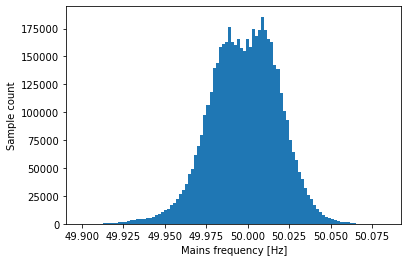

In [7]:
bin_sizes, _, _ = plt.hist(df_f_clean, bins=100)
plt.ylabel('Sample count')
plt.xlabel('Mains frequency [Hz]');

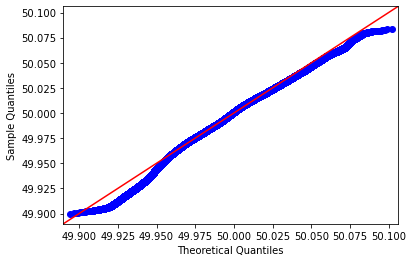

In [8]:
qqplot = sm.qqplot(df_f_clean, loc=f_mean, scale=f_std, line="45")
plt.show()

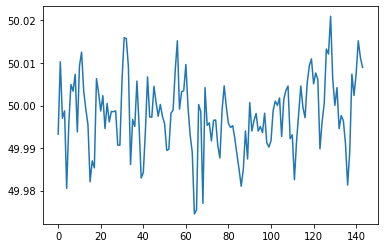

In [9]:
df_f = df_f_clean
# Downsampling
# Note: df_f_clean has 50/5 samples per second due to downsampling
df_f_ds = df_f.groupby(np.arange(len(df_f))//(50/5*3600)).mean()
_ = df_f_ds.plot(y='f_mains_syncd', use_index=True)

In [10]:
# The regular interval for mains frequency is [49.8 Hz,50.2 Hz]. 
# Any frequency outside this interval is considered abnormal. 
# We consider distortions of a single wave where a single long period 
# is followed by a single short period or vice versa as uncritical. 
# The median filter filters out such distortions. Here we can check 
# whether such distortions actually occur in the original dataset.
df_abnormal = df.loc[(df.f_mains_syncd > 50.2) | (df.f_mains_syncd < 49.8)]
df_abnormal.head()

,f_mains,f_mains_syncd,f_clk_syncd,clk_accuracy_ppm,t_wallclock,t_wallclock_str
7583282,50.2517,50.2509,41999295,17,1663783672537745292,2022-09-21 18:07:52
7583283,49.6986,49.6977,41999295,17,1663783672537745292,2022-09-21 18:07:52
12498927,50.3344,50.3335,41999300,17,1663881991749198417,2022-09-22 21:26:31
12498928,49.6748,49.6740,41999300,17,1663881991749198417,2022-09-22 21:26:31
18752295,50.9997,50.9989,41999305,17,1664007073450233566,2022-09-24 08:11:13


In [11]:
fclk_min = df.f_clk_syncd.min()
fclk_max = df.f_clk_syncd.max()
fclk_mean = np.mean(df.f_clk_syncd)
fclk_std = np.std(df.f_clk_syncd)
fclk_sem = stats.sem(df.f_clk_syncd)

# 95 % confidence interval
fclkmean_l,fclkmean_h = stats.norm.interval(0.95, loc=fclk_mean, scale=fclk_sem)

print("min(f) = " + str(fclk_min) + " Hz")
print("max(f) = " + str(fclk_max) + " Hz")
print("mean(f) = " + str(fclk_mean) + " Hz" + "\t\t95% conf. int. = [" + str(fclkmean_l) + "," + str(fclkmean_h) + "]")

min(f) = 41998753 Hz
max(f) = 42000406 Hz
mean(f) = 41999298.256911 Hz		95% conf. int. = [41999298.24929033,41999298.26453167]


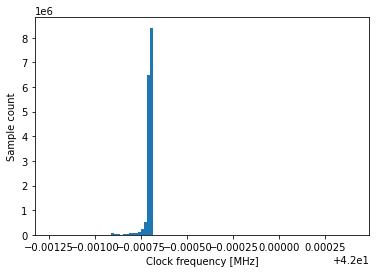

In [10]:
bin_sizes, _, _ = plt.hist(df.f_clk_syncd/1000000, bins=100)
plt.ylabel('Sample count')
plt.xlabel('Clock frequency [MHz]');

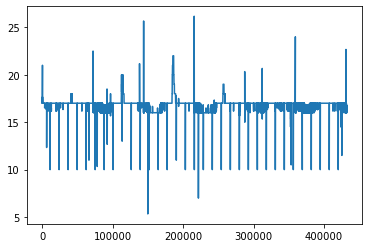

In [12]:
df_acc = df.clk_accuracy_ppm
# Downsample by calculating mean value for each minute (60 samples)
df_acc_ds = df_acc.groupby(np.arange(len(df_acc))//60).mean()
_ = df_acc_ds.plot(y='clk_accuracy_ppm', use_index=True)

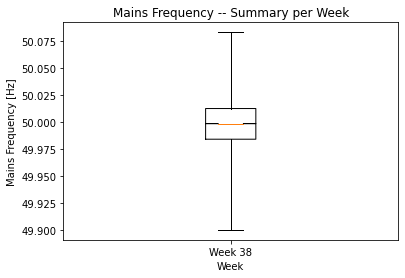

In [13]:
df_week38 = pd.read_csv('data-clean-2022week38.csv').f_mains_syncd
data_week38 = df_week38.groupby(np.arange(len(df_week38))//5).median()

data = [data_week38]

labels = ['Week 38']
_ = plt.boxplot(data, notch=True, whis=[0,100], labels=labels)
plt.ylabel('Mains Frequency [Hz]')
plt.xlabel('Week');
plt.title('Mains Frequency -- Summary per Week');